In [24]:
#<GRADED>
import numpy as np
from numpy.matlib import repmat
import sys
import time
from cvxpy import *
from l2distance import l2distance
#</GRADED>
import matplotlib
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from visclassifier import visclassifier

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/

<!--announcements-->
<blockquote>
    <center>
    <img src="yinyang.png" width="400px" /></a>
    </center>
      <p><cite><center>"Just as we have two eyes and two feet,<br>
      duality is part of life."<br>
<b>--Carlos Santana</b><br>
      </center></cite></p>
</blockquote>


<h3>Introduction</h3>
In this project, you will implement a **linear** support vector machine and one operating in kernel space. For this you will need to formulate the primal and dual optimization problems as quadratic programs. You will be using <code>cvxpy</code>. Before we get started please read through the <a href="http://www.cvxpy.org/en/latest/tutorial/index.html">tutorial</a> of cvxpy and its quadratic programming solver.

<h4> Linear classification</h4>

<p> The first assignment is to implement a linear support vector machine. Before we get started we can generate some data to see if everything is working:  
</p>

In [25]:
def genrandomdata(n=100,b=0.): # b is biass
    # generate random data and linearly separagle labels
    xTr = np.random.randn(n, 2) # n 2-dim pts
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return xTr, yTr

<p>Remember the SVM primal formulation
$$\begin{aligned}
             &\min_{\mathbf{w},b,\xi} \|\mathbf{w}\|^2_2+C \sum_{i=1}^n \xi_i\\
       & \text{such that }  \ \forall i:\\
             & y_i(\mathbf{w}^\top \mathbf{x}_i+b)\geq 1-\xi_i\\
             & \xi_i\geq 0.\\
\end{aligned}
$$
You will need to implement  the function <code>SVMprimal</code>, which  takes is important training data <code>xTr</code> ($n\times d$) and labels <code>yTr</code> ($n\times 1$) with <code>yTr[i]</code>$\in \{-1,1\}$. Currently, the code below is a placeholder example of a <code>cvxpy</code> optimization problem. You need to update the objective, the constraints and introduce new variables to output the correct hyperplane and bias. </p>

In [26]:
#<GRADED>
def primalSVM(xTr, yTr, C=1):
    """
    function (classifier,w,b) = primalSVM(xTr,yTr;C=1)
    constructs the SVM primal formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
    
    Output:
        fun   | usage: predictions=fun(xTe);
        wout  | the weight vector calculated by the solver
        bout  | the bias term calculated by the solver
    """
    N, d = xTr.shape
    y = yTr.flatten()
    # dummy code: example of establishing objective and constraints, and let the solver solve it.
    w = Variable(d) # from cvxpy
    b = Variable(1) 
    slack = Variable(N)
    
    objective = sum_squares(w) + C*sum_entries(slack)
    constraints = [mul_elemwise(y, xTr*w+b)>= 1 - slack, slack >= 0]

    #objective = sum_squares(w) + C * sum_entries(1-(mul_elemwise(y, xTr*w+b))# from cvxpy
    #objective = sum_squares(w) + C * sum_entries(max_elemwise(1 - yTr * (xTr * w + b), 0))# from cvxpy
    
    # update constraints
    #constraints = [1 - yTr * (xTr * w + b) >= 0]
    prob = Problem(Minimize(objective), constraints) # cvxpy
    prob.solve()
    wout = w.value
    bout = b.value
    # End of dummy code
    
    # TODO 1
    
    fun = lambda x: x.dot(wout) + bout
    return fun, wout, bout
#</GRADED>

We can test your SVM primal solver with the following randomly generated data set. We label it in a way that it is guaranteed to be linearly separable. If your code works correctly the hyper-plane should separate all the $x$'s into the red half and all the $o$'s into the blue half. With sufficiently large values of $C$ (e.g. $C>10$) you should obtain $0\%$ training error. 

In [27]:
def arrayify(x):
    """flattens and converts to numpy"""
    return np.array(x).flatten()

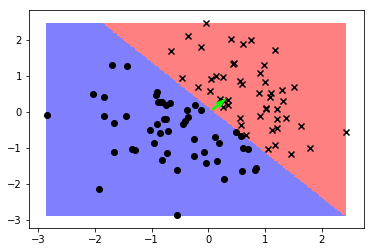

Training error: 0.0%


In [28]:
xTr,yTr=genrandomdata()
fun,w,b=primalSVM(xTr,yTr,C=10)
visclassifier(fun,xTr,yTr,w=w,b=b)

err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

<h4>Spiral data set</h4>

<p>The linear classifier works great in simple linear cases. But what if the data is more complicated? We provide you with a "spiral" data set. You can load it and visualize it with the following two code snippets:
<pre>

In [29]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

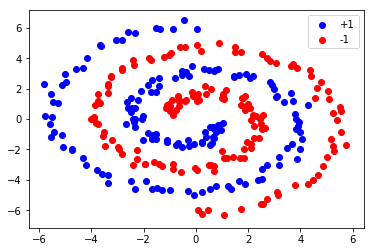

In [30]:
xTr,yTr,xTe,yTe=spiraldata()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

<p>If you apply your previously functioning linear classifier on this data set you will see that you get terrible results. Your training error will increase drastically. </p>

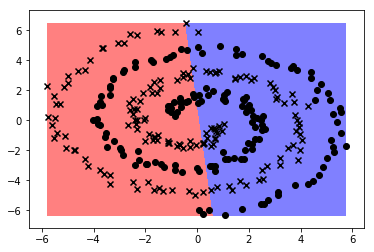

Training error: 42.3%


In [31]:
fun,w,b=primalSVM(xTr,yTr,C=10)
visclassifier(fun,xTr,yTr,w=[],b=0)
err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

<h3>Implementing a kernelized SVM</h3>

<p> For something as complex as the spiral data set, you need a more complex classifier. 
First implement the kernel function
<pre>	computeK(kerneltype,X,Z,kpar)</pre>
It takes as input a kernel type (kerneltype) and two data sets $\mathbf{X}$ in $\mathcal{R}^{n\times d}$ and $\mathbf{Z}$ in $\mathcal{R}^{m\times d}$ and outputs a kernel matrix $\mathbf{K}\in{\mathcal{R}^{n\times m}}$. The last input, <code>kpar</code> specifies the kernel parameter (e.g. the inverse kernel width $\gamma$ in the RBF case or the degree $p$ in the polynomial case.)
	<ol>
	<li>For the linear kernel (<code>ktype='linear'</code>) svm, use $k(\mathbf{x},\mathbf{z})=x^Tz$ </li> 
	<li>For the radial basis function kernel (<code>ktype='rbf'</code>) svm use $k(\mathbf{x},\mathbf{z})=\exp(-\gamma ||x-z||^2)$ (gamma is a hyperparameter, passed a the value of kpar)</li>
	<li>For the polynomial kernel (<code>ktype='poly'</code>) use  $k(\mathbf{x},\mathbf{z})=(x^Tz + 1)^p$ (p is the degree of the polymial, passed as the value of kpar)</li>
</ol>

<p>You can use the function <b><code>l2distance</code></b> as a helperfunction.</p>





In [80]:
#<GRADED>
def computeK(kerneltype, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=g(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kerneltype: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (dxn);
    Z: m input vectors of dimension d (dxm);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel matrix
    """
    
    assert kerneltype in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kerneltype
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    # TODO 2
    if kerneltype == "linear":
        K = np.dot(X, Z.T)
    elif kerneltype == "rbf":
        K = np.exp(-kpar * np.power(l2distance(X, Z), 2))
    else:
        K = np.power(np.dot(X, Z.T) + 1, kpar)
    return K
#</GRADED>

<p>The following code snippet plots an image of the kernel matrix for the data points in the spiral set. Use it to test your <b><code>computeK</code></b> function:</p>

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in power


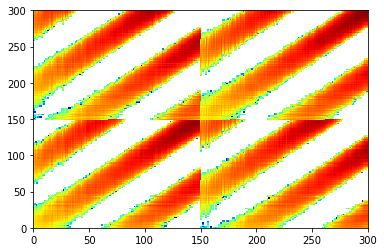

In [81]:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("poly",xTr,xTr,kpar=0.05)
# plot an image of the kernel matrix
plt.pcolormesh(K, cmap='jet')
plt.show()

Remember that the SVM optimization has the following dual formulation:
$$
\begin{aligned}
             &\min_{\alpha_1,\cdots,\alpha_n}\frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{K}_{ij} - \sum_{i=1}^{n}\alpha_i  \\
       \text{s.t.}  &\quad 0 \leq \alpha_i \leq C\\
             &\quad \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}
$$
This is equivalent to solving for the SVM primal
$$ L(\mathbf{w},b) = C\sum_{i=1}^n \max(1-y_i(\mathbf{w}^\top\phi(\mathbf{x}_i)+b),0) + ||w||_2^2$$
where $\mathbf{w}=\sum_{i=1}^n y_i \alpha_i \phi(\mathbf{x}_i)$ and $\mathbf{K}_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)=\phi(\mathbf{x}_i)^\top\phi(\mathbf{x}_j)$, for some mapping $\phi(\cdot)$.  Please note that here all $\alpha_i\geq 0$, which is possible because we multiply by $y_i$ in the definition of $\mathbf{w}$. One advantage of keeping all $\alpha_i$ non-negative is that we can easily identify non-support vectors as vectors with $\alpha_i=0$. 

<p>Implement the function <code>dualqp</code>, which takes as input a kernel matrix $K$, a vector of labels $yTr$ in $\mathcal{R}^{n}$, and a regularization constant $C\geq 0$. This function should solve the quadratic optimization problem and output the optimal vector $\mathbf{\alpha}\in{\mathcal{R}^n}$.</p>



In [34]:
#<GRADED>
def dualqp(K,yTr,C):
    """
    function alpha = dualqp(K,yTr,C)
    constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        K     | the (nxn) kernel matrix
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
    
    Output:
        alpha | the calculated solution vector (nx1)
    """
    y = yTr.flatten()
    N, _ = K.shape
    alpha = Variable(N)
    
    # TODO 3:
#   aa = mul_elemwise(alpha, alpha.T)
#    yy = np.matmul(yTr, yTr.T)
   
    objective = 0.5 * sum_entries(quad_form(mul_elemwise(y, alpha), K)) - sum_entries(alpha)
    constraints = [alpha >=0, alpha <= C, sum(mul_elemwise(y, alpha)) == 0]
    
    prob = Problem(Minimize(objective), constraints) # cvxpy
    prob.solve()
    
    
    return np.array(alpha.value)
#</GRADED>

The following code shows a usecase of how <code>dualqp</code> could be used in practice. 

In [35]:
C = 10
lmbda = 0.25
ktype = "rbf"
xTr,yTr,xTe,yTe=spiraldata()
# compute kernel (make sure it is PSD)
K = computeK(ktype,xTr,xTr)
eps = 1e-10
# make sure it is symmetric and positive semi-definite
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])

alpha=dualqp(K,yTr,C)

<p> Now that you can solve the dual correctly, you should have the values for $\alpha_i$. But you are not done yet. You still need to be able to classify new test points. Remember from class that $h(\mathbf{x})=\sum_{i=1}^n \alpha_i y_i k(\mathbf{x}_i,\mathbf{x})+b$. You need to obtain $b$. It is easy to show (and omitted here) that if $C>\alpha_i>0$ (with strict $>$), then we must have that $y_i(\mathbf{w}^\top \phi(\mathbf{x}_i)+b)=1$. Rephrase this equality in terms of $\alpha_i$ and solve for $b$. Implement

<p> b=recoverBias(K,yTr,alphas,C); </p>

<p> where <code>b</code> is the hyperplane bias.
(Hint: This is most stable if you pick an $\alpha_i$ that is furthest from $C$ and $0$. )</p>

<p>Please note that this use of the word bias has absolutely nothing to do with the word bias in the bias variance trade-off. This unfortunate term collision comes from the fact that we are borrowing concepts from geometry and statistics.</p>

In [55]:
#<GRADED>
def recoverBias(K,yTr,alpha,C):
    """
    function bias=recoverBias(K,yTr,alpha,C);
    Solves for the hyperplane bias term, which is uniquely specified by the 
    support vectors with alpha values 0<alpha<C
    
    INPUT:
    K : nxn kernel matrix
    yTr : 1xn input labels
    alpha  : nx1 vector of alpha values
    C : regularization constant
    
    Output:
    bias : the scalar hyperplane bias of the kernel SVM specified by alphas
    """
    
    # TODO 4
    idx = np.argmin(alpha - 0.5 * C)
    return yTr[idx] - np.sum(yTr[idx] * alpha[idx] * K[:, idx])
#</GRADED>

<p> Test your <b><code>recoverBias</code></b> function with the following code, which uses the dual solver on a linearly separable dataset:</p>

In [50]:
yTr[0].shape

()

(1, 100)
(100,)
(1, 100)
(100, 2)
(2, 1)


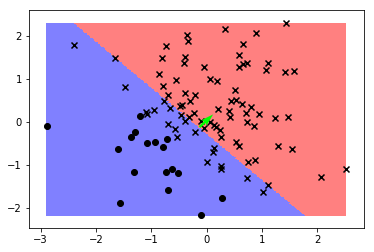

In [66]:
xTr,yTr=genrandomdata(b=0.5)
C=10
K=computeK("linear",xTr,xTr)
eps=1e-10
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])
alpha = dualqp(K,yTr,C)
print(alpha.T.shape)
print(yTr.shape)
print((alpha.T*yTr).shape)
print(xTr.shape)
ba=recoverBias(K,yTr,alpha,C)
wa = ((alpha.T * yTr).dot(xTr)).T
fun = lambda x: x.dot(wa) + ba
print(wa.shape)
visclassifier(fun, xTr, yTr, w=wa, b=ba)

In [67]:
alpha.shape

(100, 1)

In [68]:
(yTr * alpha.T).shape

(1, 100)

<p>
    Implement the function 
    <pre>
    svmclassify=dualSVM(xTr,yTr,C,ktype,kpar);
    </pre>
    It should use your functions <code><b>computeK</b></code> and <code><b>generateQP</b></code> to solve the SVM dual problem of an SVM specified by a training data set (<code><b>xTr,yTr</b></code>), a regularization parameter (<code>C</code>), a kernel type (<code>ktype</code>) and kernel parameter (<code>lmbda</code>, to be used as kpar in Kernel construction). Then, find the support vectors and recover the bias to return <b><code>svmclassify</code></b>, a function that uses your SVM to classify a set of test points <code>xTe</code>.

    
</p>


In [84]:
#<GRADED>
def dualSVM(xTr,yTr,C,ktype,lmbda):
    """
    function classifier = dualSVM(xTr,yTr,C,ktype,lmbda);
    Constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
        ktype | the type of kernelization: 'rbf','polynomial','linear'
        lmbda | the kernel parameter - degree for poly, inverse width for rbf
    
    Output:
        svmclassify | usage: predictions=svmclassify(xTe);
    """
    
    # TODO 5
    K = computeK(ktype, xTr, xTr, lmbda)
    alpha = dualqp(K, yTr, C)
    b = recoverBias(K,yTr,alpha,C)
#    svmclassify = lambda x: np.sign(np.matmul((np.array(yTr) * np.array(alpha).T), computeK(ktype, xTr, x, lmbda))+b).reshape(-1,)
#    svmclassify = lambda x: np.sum(alpha*yTr*computeK(ktype,x,xTr,lmbda), axis=1)
    svmclassify = lambda x: np.sum(yTr*alpha.T*computeK(ktype,x,xTr,lmbda), axis=1)
    return svmclassify
#</GRADED>

<p>Now we try the SVM with RBF kernel on the spiral data. If you implemented it correctly, train and test error should be close to zero.</p>

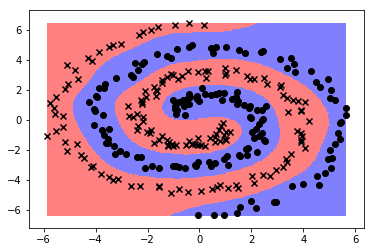

Training error: 0.0000
Testing error: 0.0000


In [85]:
xTr,yTr,xTe,yTe=spiraldata()
C=10.0
sigma=0.25
ktype="rbf"
svmclassify=dualSVM(xTr,yTr,C,ktype,sigma)

visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=np.mean(np.sign(predsTr)!=yTr)
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=np.mean(np.sign(predsTe)!=yTe)
print("Testing error: %2.4f" % testingerr)

SVMs are pretty sensitive to hyper-parameters. We can visualize the results of a hyper-parameter grid search as a heat-map, where we sweep across different values of C and kpar and output the result on a validation dataset. Now we ask you to implement a cross-validation function.

In [86]:
#<GRADED>
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        ErrorMatrix| the test error rate for each given C and Lmbda when trained on (xTr,yTr) and tested on (xValid,yValid),(axb)
    """
    # gridsearch for best parameters
    ErrorMatrix=np.zeros((len(CList),len(lmbdaList)))
    bestC,bestLmbda = 0.,0.
    
    # TODO 6
    for i in range(len(CList)):
        for j in range(len(lmbdaList)):
            cur_model = dualSVM(xTr,yTr,CList[i],ktype,lmbdaList[j])
            predsTe=cur_model(xValid)
            ErrorMatrix[i, j] = np.mean(np.sign(predsTe)!=yValid)
    i,j = np.unravel_index(ErrorMatrix.argmin(), ErrorMatrix.shape)
    bestC = CList[i]
    bestLmbda = lmbdaList[j]
    return bestC,bestLmbda,ErrorMatrix
#</GRADED>

In [87]:
ErrorMatrix

array([[0.5 , 0.48, 0.46, 0.48, 0.43],
       [0.43, 0.37, 0.3 , 0.23, 0.26],
       [0.35, 0.34, 0.23, 0.22, 0.23],
       [0.33, 0.26, 0.17, 0.15, 0.19],
       [0.36, 0.15, 0.14, 0.15, 0.19],
       [0.34, 0.13, 0.14, 0.15, 0.19],
       [0.33, 0.21, 0.14, 0.15, 0.19]])

[ 0.5  1.   2.   4.   8.  16.  32. ]
[0.1 0.2 0.3 0.4 0.5]


Text(0.5,1,'Validation error')

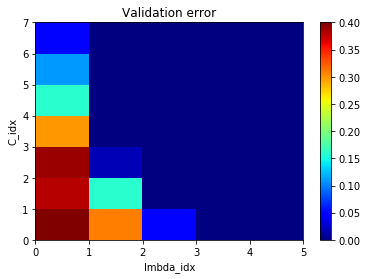

In [88]:
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-1,5,7))
lmbdaList=(np.linspace(0.1,0.5,5))
print(CList)
print(lmbdaList)

bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList)

plt.pcolormesh(ErrorMatrix, cmap='jet')
plt.colorbar()
plt.xlabel("lmbda_idx")
plt.ylabel("C_idx")
plt.title("Validation error")

If you implemented everything correctly, the result should look similar to this image:
<center>
 <img src="crossval.png" width="300px" />
</center>

Competition: we ask you to implement function autosvm, which given xTr and yTr, splits them into training data and validation data, and then uses a hyperparameter search to find the optimal hyper parameters. 

Function autosvm should return a function which will act as a classifier on xTe.

You have a 5 minute time limit on multiple datasets, each dataset having different optimal hyperparameters, so you should strive for a good method of finding hyperparameters (within the time limit) instead of just trying to find a static set of good hyperparameters. 

You will get extra credit for the competition if you can beat the base benchmark of 34% error rate.

In [ ]:
#<GRADED>
def autosvm(xTr,yTr):
    """
    svmclassify = autosvm(xTr,yTr), where yTe = svmclassify(xTe)
    """

# (Optional) TODO 7

#</GRADED>